In [28]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import reedsolo

data = "Kookmin"
print(f"data : {data}")
character_count = len(data)
print(f"len of data: {character_count}")

bits = list(itertools.chain.from_iterable([list(map(int, f"{ord(c):08b}")) for c in data]))
print("tx bits: ", bits)

binary_str = ''.join(map(str, bits))
print(f"Transmitted Signal: {list(binary_str)}") 

byte_array = bytearray()
for i in range(0, len(binary_str), 8):
    byte_array.append(int(binary_str[i:i+8], 2))
data_bytes = bytes(byte_array)

n = 15
k = 11
rs = reedsolo.RSCodec(n - k)
encoded_data = rs.encode(data_bytes)

encoded_binary = ''.join(f'{byte:08b}' for byte in encoded_data)
print(f"FEC Encoded binary data: {encoded_binary}")

binary_list = [int(bit) for bit in encoded_binary]
print(f"binary_list : {binary_list}")

M = 4
bits_per_symbol = int(np.log2(M))
pad_length = (bits_per_symbol - len(binary_list) % bits_per_symbol) % bits_per_symbol
padded_bits = np.append(binary_list, [0] * pad_length)

mapping = {
    '00':  1+1j,
    '01':  1-1j,
    '11': -1-1j,
    '10': -1+1j
}

symbols = []
for i in range(0, len(padded_bits), bits_per_symbol):
    bit_group = ''.join(str(int(bit)) for bit in padded_bits[i:i+bits_per_symbol])
    symbols.append(mapping[bit_group])

qam_symbols = np.array(symbols)
print(f"QAM-4 Symbols (one row per subcarrier):{qam_symbols}")
print ("len qam_symbols:", len(qam_symbols))

data : Kookmin
len of data: 7
tx bits:  [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Transmitted Signal: ['0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0']
FEC Encoded binary data: 0100101101101111011011110110101101101101011010010110111010101001111000000011101100111000
binary_list : [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
QAM-4 Symbols (one row per subcarrier):[ 1.-1.j  1.+1.j -1.+1.j -1.-1.j  1.-1.j -1.+1.j -1.-1.j -

In [29]:
symbols_per_ofdm = 7
num_ofdm_symbols = len(qam_symbols) // symbols_per_ofdm
ofdm_symbols = []
hermitian_symmetric_all = []
for i in range(num_ofdm_symbols):
    start_idx = i * symbols_per_ofdm
    end_idx = start_idx + symbols_per_ofdm
    qam_chunk = qam_symbols[start_idx:end_idx]

    N = 16
    hermitian_symmetric = np.zeros(N, dtype=complex)
    hermitian_symmetric[1:8] = qam_chunk[0:7]
    hermitian_symmetric[8] = 0
    hermitian_symmetric[9] = np.conj(qam_chunk[6])
    hermitian_symmetric[10:15] = np.conj(qam_chunk[1:6])[::-1]
    hermitian_symmetric[15] = np.conj(qam_chunk[0])

    hermitian_symmetric_all.append(hermitian_symmetric)

    time_domain_ofdm = np.fft.ifft(hermitian_symmetric)
    ofdm_symbols.append(time_domain_ofdm)

print ("hermitian_symmetric", hermitian_symmetric_all)
ofdm_symbols = np.array(ofdm_symbols)



hermitian_symmetric [array([ 0.+0.j,  1.-1.j,  1.+1.j, -1.+1.j, -1.-1.j,  1.-1.j, -1.+1.j,
       -1.-1.j,  0.+0.j, -1.+1.j, -1.-1.j,  1.+1.j, -1.+1.j, -1.-1.j,
        1.-1.j,  1.+1.j]), array([ 0.+0.j, -1.-1.j,  1.-1.j, -1.+1.j, -1.-1.j, -1.-1.j,  1.-1.j,
       -1.+1.j,  0.+0.j, -1.-1.j,  1.+1.j, -1.+1.j, -1.+1.j, -1.-1.j,
        1.+1.j, -1.+1.j]), array([ 0.+0.j, -1.+1.j, -1.-1.j,  1.-1.j, -1.+1.j, -1.-1.j,  1.-1.j,
        1.-1.j,  0.+0.j,  1.+1.j,  1.+1.j, -1.+1.j, -1.-1.j,  1.+1.j,
       -1.+1.j, -1.-1.j]), array([ 0.+0.j, -1.+1.j, -1.+1.j,  1.-1.j,  1.-1.j, -1.+1.j, -1.-1.j,
       -1.+1.j,  0.+0.j, -1.-1.j, -1.+1.j, -1.-1.j,  1.+1.j,  1.+1.j,
       -1.-1.j, -1.-1.j]), array([ 0.+0.j, -1.+1.j, -1.+1.j, -1.+1.j,  1.-1.j, -1.-1.j, -1.+1.j,
        1.+1.j,  0.+0.j,  1.-1.j, -1.-1.j, -1.+1.j,  1.+1.j, -1.-1.j,
       -1.-1.j, -1.-1.j]), array([ 0.+0.j,  1.+1.j,  1.+1.j, -1.-1.j, -1.+1.j, -1.-1.j,  1.+1.j,
       -1.-1.j,  0.+0.j, -1.+1.j,  1.-1.j, -1.+1.j, -1.-1.j, -1.+1.j,
    

In [30]:
print("Time-Domain OFDM Symbols:")
print(ofdm_symbols)

Time-Domain OFDM Symbols:
[[-0.125     +0.j  0.35596988+0.j -0.0517767 +0.j  0.07905723+0.j
   0.125     +0.j  0.02932914+0.j -0.0517767 +0.j  0.18892522+0.j
  -0.125     +0.j -0.10596988+0.j  0.3017767 +0.j -1.03616401+0.j
  -0.375     +0.j  0.22067086+0.j  0.3017767 +0.j  0.26818156+0.j]
 [-0.375     +0.j  0.3017767 +0.j  0.125     +0.j  0.0517767 +0.j
   0.125     +0.j -0.0517767 +0.j  0.125     +0.j -0.3017767 +0.j
   0.625     +0.j  0.3017767 +0.j  0.125     +0.j  0.0517767 +0.j
  -0.875     +0.j -0.0517767 +0.j  0.125     +0.j -0.3017767 +0.j]
 [-0.125     +0.j -0.02932914+0.j -0.0517767 +0.j  0.05624179+0.j
  -0.375     +0.j  0.10596988+0.j -0.0517767 +0.j  0.13771552+0.j
  -0.125     +0.j -0.22067086+0.j  0.3017767 +0.j  0.90086499+0.j
   0.125     +0.j -0.35596988+0.j  0.3017767 +0.j -0.5948223 +0.j]
 [-0.375     +0.j  0.125     +0.j -0.375     +0.j -0.58693977+0.j
   0.125     +0.j  0.125     +0.j  0.47855339+0.j -0.31634172+0.j
   0.125     +0.j  0.125     +0.j -0.375     +0

In [31]:

tx_signal_combined_real = np.concatenate([ofdm.real for ofdm in ofdm_symbols])
tx_signal_combined_imag = np.concatenate([ofdm.imag for ofdm in ofdm_symbols])

print("combine real of ofdm", tx_signal_combined_real)


combine real of ofdm [-0.125       0.35596988 -0.0517767   0.07905723  0.125       0.02932914
 -0.0517767   0.18892522 -0.125      -0.10596988  0.3017767  -1.03616401
 -0.375       0.22067086  0.3017767   0.26818156 -0.375       0.3017767
  0.125       0.0517767   0.125      -0.0517767   0.125      -0.3017767
  0.625       0.3017767   0.125       0.0517767  -0.875      -0.0517767
  0.125      -0.3017767  -0.125      -0.02932914 -0.0517767   0.05624179
 -0.375       0.10596988 -0.0517767   0.13771552 -0.125      -0.22067086
  0.3017767   0.90086499  0.125      -0.35596988  0.3017767  -0.5948223
 -0.375       0.125      -0.375      -0.58693977  0.125       0.125
  0.47855339 -0.31634172  0.125       0.125      -0.375       0.33693977
  0.625       0.125      -0.22855339  0.06634172 -0.375      -0.37841744
 -0.125      -0.62841744  0.625       0.16647767 -0.47855339  0.18707572
  0.125       0.27486405 -0.125       0.02486405  0.125       0.43707572
  0.22855339 -0.08352233 -0.125       0

In [32]:

alpha = 1.5
percentile_value = 85
sigma_x_t = np.std(tx_signal_combined_real)
b = alpha * sigma_x_t
biased_signal = (tx_signal_combined_real + b)*20
A = np.percentile(biased_signal, percentile_value)
clipped_signal = np.clip(biased_signal, 0, A)

clipped_signal_example = np.array([clipped_signal])
# transmitted_signal = clipped_signal_example + 200

print("transmitted signal clipped", clipped_signal_example)
# print("transmitted_signal: ", transmitted_signal)

transmitted signal clipped [[ 7.42156742 15.95710132  8.88603351 11.50271209 12.42156742 10.50815025
   8.88603351 13.70007189  7.42156742  7.80216975 15.95710132  0.
   2.42156742 14.33498458 15.95710132 15.28519857  2.42156742 15.95710132
  12.42156742 10.95710132 12.42156742  8.88603351 12.42156742  3.88603351
  15.95710132 15.95710132 12.42156742 10.95710132  0.          8.88603351
  12.42156742  3.88603351  7.42156742  9.33498458  8.88603351 11.04640324
   2.42156742 12.04096508  8.88603351 12.67587777  7.42156742  5.50815025
  15.95710132 15.95710132 12.42156742  2.80216975 15.95710132  0.
   2.42156742 12.42156742  2.42156742  0.         12.42156742 12.42156742
  15.95710132  3.59473309 12.42156742 12.42156742  2.42156742 15.95710132
  15.95710132 12.42156742  5.3504996  11.24840174  2.42156742  2.35321869
   7.42156742  0.         15.95710132 13.25112082  0.3504996  13.66308182
  12.42156742 15.41884833  7.42156742 10.41884833 12.42156742 15.95710132
  14.49263523  8.25112082  

In [33]:


normalized_signal = np.round(clipped_signal_example).astype(int).reshape(-1)
print(f"Normalized Signal Length: {len(normalized_signal)}")
OFDM_signal = normalized_signal  
print ("Pure OFDM", OFDM_signal)

Normalized Signal Length: 96
Pure OFDM [ 7 16  9 12 12 11  9 14  7  8 16  0  2 14 16 15  2 16 12 11 12  9 12  4
 16 16 12 11  0  9 12  4  7  9  9 11  2 12  9 13  7  6 16 16 12  3 16  0
  2 12  2  0 12 12 16  4 12 12  2 16 16 12  5 11  2  2  7  0 16 13  0 14
 12 15  7 10 12 16 14  8  7 13 12  9  0  7  5 16 16  0 12  9  7 15 16 16]


In [34]:


OFDM_signal = ', '.join(map(str, normalized_signal))
Data_ofdm = OFDM_signal
Data_ofdm = list(map(int, Data_ofdm.split(',')))  # Konversi menjadi list of int
print ("\nPure OFDM for adding 0:", Data_ofdm)


Pure OFDM for adding 0: [7, 16, 9, 12, 12, 11, 9, 14, 7, 8, 16, 0, 2, 14, 16, 15, 2, 16, 12, 11, 12, 9, 12, 4, 16, 16, 12, 11, 0, 9, 12, 4, 7, 9, 9, 11, 2, 12, 9, 13, 7, 6, 16, 16, 12, 3, 16, 0, 2, 12, 2, 0, 12, 12, 16, 4, 12, 12, 2, 16, 16, 12, 5, 11, 2, 2, 7, 0, 16, 13, 0, 14, 12, 15, 7, 10, 12, 16, 14, 8, 7, 13, 12, 9, 0, 7, 5, 16, 16, 0, 12, 9, 7, 15, 16, 16]


In [35]:

min_value = np.min(normalized_signal)
max_value = np.max(normalized_signal)
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}\n")

print("Pure OFDM     = ", Data_ofdm)
print(f"Normalized Signal Length Before: {len(normalized_signal)}")


Minimum value: 0
Maximum value: 16

Pure OFDM     =  [7, 16, 9, 12, 12, 11, 9, 14, 7, 8, 16, 0, 2, 14, 16, 15, 2, 16, 12, 11, 12, 9, 12, 4, 16, 16, 12, 11, 0, 9, 12, 4, 7, 9, 9, 11, 2, 12, 9, 13, 7, 6, 16, 16, 12, 3, 16, 0, 2, 12, 2, 0, 12, 12, 16, 4, 12, 12, 2, 16, 16, 12, 5, 11, 2, 2, 7, 0, 16, 13, 0, 14, 12, 15, 7, 10, 12, 16, 14, 8, 7, 13, 12, 9, 0, 7, 5, 16, 16, 0, 12, 9, 7, 15, 16, 16]
Normalized Signal Length Before: 96


In [36]:


max_length = 100
# Tambahkan 0 hingga panjang array mencapai max_length
Data_ofdm.extend([0] * (max_length - len(Data_ofdm)))

# Tampilkan panjang array yang telah dimodifikasi
# print(f"Normalized Signal = {normalized_signal}")
print(f"\nPure OFDM+0*8 = {Data_ofdm}")
print(f"Normalized Signal Length Afterr: {len(Data_ofdm)}")




Pure OFDM+0*8 = [7, 16, 9, 12, 12, 11, 9, 14, 7, 8, 16, 0, 2, 14, 16, 15, 2, 16, 12, 11, 12, 9, 12, 4, 16, 16, 12, 11, 0, 9, 12, 4, 7, 9, 9, 11, 2, 12, 9, 13, 7, 6, 16, 16, 12, 3, 16, 0, 2, 12, 2, 0, 12, 12, 16, 4, 12, 12, 2, 16, 16, 12, 5, 11, 2, 2, 7, 0, 16, 13, 0, 14, 12, 15, 7, 10, 12, 16, 14, 8, 7, 13, 12, 9, 0, 7, 5, 16, 16, 0, 12, 9, 7, 15, 16, 16, 0, 0, 0, 0]
Normalized Signal Length Afterr: 100


In [37]:
#kode diupdate ---- 01232025
import numpy as np

def text_to_bits(text):
    return ''.join(format(ord(char), '08b') for char in text)

def add_preamble(bit_stream, preamble="00"):
    return preamble + bit_stream

# Get input data
input_data = "4" 
print("input data: Drone number", input_data)

# Convert text to binary
bit_stream = text_to_bits(input_data)
print("Bit Stream:", bit_stream)

# Add preamble
preamble_data = add_preamble(bit_stream)
print("Data with Preamble:", preamble_data)

OOK_signal = [1 if bit == '1' else 0 for bit in preamble_data] 
print("OOK Signal:", OOK_signal)

input data: Drone number 4
Bit Stream: 00110100
Data with Preamble: 0000110100
OOK Signal: [0, 0, 0, 0, 1, 1, 0, 1, 0, 0]


In [38]:
#HOOK OFDM
# Assuming OOK_signal and OFDM_signal are predefined
OOK = OOK_signal
print("ook data", OOK)

# Ensure hello1 (OFDM_signal) is a list of integers
if isinstance(Data_ofdm, str):
    # Remove any non-numeric characters (like commas) and then split the string into individual numbers
    hello1 = list(map(int, Data_ofdm.replace(',', '').split()))  # This removes commas and splits the string
else:
    hello1 = Data_ofdm  # If OFDM_signal is already a list, use it directly

# Calculate the chunk size = hello = 200, ook = 40, jadi 200/40 = 5 bit per 1 ook
chunk_size = len(hello1) // len(OOK)

# Pad hello1 to ensure it can be evenly divided by OOK length
padding_size = len(OOK) * chunk_size - len(hello1)
hello1.extend([0] * padding_size)
print("Padded hello1:", hello1)

ook data [0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Padded hello1: [7, 16, 9, 12, 12, 11, 9, 14, 7, 8, 16, 0, 2, 14, 16, 15, 2, 16, 12, 11, 12, 9, 12, 4, 16, 16, 12, 11, 0, 9, 12, 4, 7, 9, 9, 11, 2, 12, 9, 13, 7, 6, 16, 16, 12, 3, 16, 0, 2, 12, 2, 0, 12, 12, 16, 4, 12, 12, 2, 16, 16, 12, 5, 11, 2, 2, 7, 0, 16, 13, 0, 14, 12, 15, 7, 10, 12, 16, 14, 8, 7, 13, 12, 9, 0, 7, 5, 16, 16, 0, 12, 9, 7, 15, 16, 16, 0, 0, 0, 0]


In [39]:

# Distribute chunks to each bit in OOK with clipping
result = []
for i, bit in enumerate(OOK):
    # Extract the chunk for the current bit
    data_chunk = hello1[i * chunk_size:(i + 1) * chunk_size]
    # Apply clipping based on the value of the bit
    if bit == 1:
        data_chunk = [value + 200 for value in data_chunk]
    else:
        data_chunk = [value + 70 for value in data_chunk]
    # Append the result with the modified data chunk
    result.append((bit, data_chunk))

# Combine all chunks into one array
combined_data = [data for _, data_chunk in result for data in data_chunk]
print(f"\nSignal Length: {len(combined_data)}")
print("HOOK OFDM DATA 1st mapping:\n", combined_data)


Signal Length: 100
HOOK OFDM DATA 1st mapping:
 [77, 86, 79, 82, 82, 81, 79, 84, 77, 78, 86, 70, 72, 84, 86, 85, 72, 86, 82, 81, 82, 79, 82, 74, 86, 86, 82, 81, 70, 79, 82, 74, 77, 79, 79, 81, 72, 82, 79, 83, 207, 206, 216, 216, 212, 203, 216, 200, 202, 212, 202, 200, 212, 212, 216, 204, 212, 212, 202, 216, 86, 82, 75, 81, 72, 72, 77, 70, 86, 83, 200, 214, 212, 215, 207, 210, 212, 216, 214, 208, 77, 83, 82, 79, 70, 77, 75, 86, 86, 70, 82, 79, 77, 85, 86, 86, 70, 70, 70, 70]


In [40]:
# High frequency mapping
high_mapping = {200: 153, 
                201: 161, 
                202: 169, 
                203: 177, 
                204: 185,
                205: 193, 
                206: 201, 
                207: 209, 
                208: 217, 
                209: 225}

# Low frequency mapping
low_mapping = {70: 73, 
               71: 81, 
               72: 89, 
               73: 97, 
               74: 105,
               75: 113, 
               76: 121, 
               77: 129, 
               78: 137, 
               79: 145}

# Map values according to high or low mapping
mapping_HOFDM = []
for value in combined_data:
    if value in high_mapping:
        mapping_HOFDM.append(high_mapping[value])
    elif value in low_mapping:
        mapping_HOFDM.append(low_mapping[value])
    else:
        mapping_HOFDM.append(value)

print(f"\nSignal Length: {len(combined_data)}")
print("HOOK OFDM DATA 2nd mapping:\n", mapping_HOFDM)

# Remove the last 8 bits
mapping_HOFDM1 = mapping_HOFDM[:-4]
print("\nHOOK OFDM-exact value before adding 0*8 bit\n", mapping_HOFDM1)
print(f"OFDM_signal_reconstructed: {len(mapping_HOFDM1)}")




Signal Length: 100
HOOK OFDM DATA 2nd mapping:
 [129, 86, 145, 82, 82, 81, 145, 84, 129, 137, 86, 73, 89, 84, 86, 85, 89, 86, 82, 81, 82, 145, 82, 105, 86, 86, 82, 81, 73, 145, 82, 105, 129, 145, 145, 81, 89, 82, 145, 83, 209, 201, 216, 216, 212, 177, 216, 153, 169, 212, 169, 153, 212, 212, 216, 185, 212, 212, 169, 216, 86, 82, 113, 81, 89, 89, 129, 73, 86, 83, 153, 214, 212, 215, 209, 210, 212, 216, 214, 217, 129, 83, 82, 145, 73, 129, 113, 86, 86, 73, 82, 145, 129, 85, 86, 86, 73, 73, 73, 73]

HOOK OFDM-exact value before adding 0*8 bit
 [129, 86, 145, 82, 82, 81, 145, 84, 129, 137, 86, 73, 89, 84, 86, 85, 89, 86, 82, 81, 82, 145, 82, 105, 86, 86, 82, 81, 73, 145, 82, 105, 129, 145, 145, 81, 89, 82, 145, 83, 209, 201, 216, 216, 212, 177, 216, 153, 169, 212, 169, 153, 212, 212, 216, 185, 212, 212, 169, 216, 86, 82, 113, 81, 89, 89, 129, 73, 86, 83, 153, 214, 212, 215, 209, 210, 212, 216, 214, 217, 129, 83, 82, 145, 73, 129, 113, 86, 86, 73, 82, 145, 129, 85, 86, 86]
OFDM_signal_recon

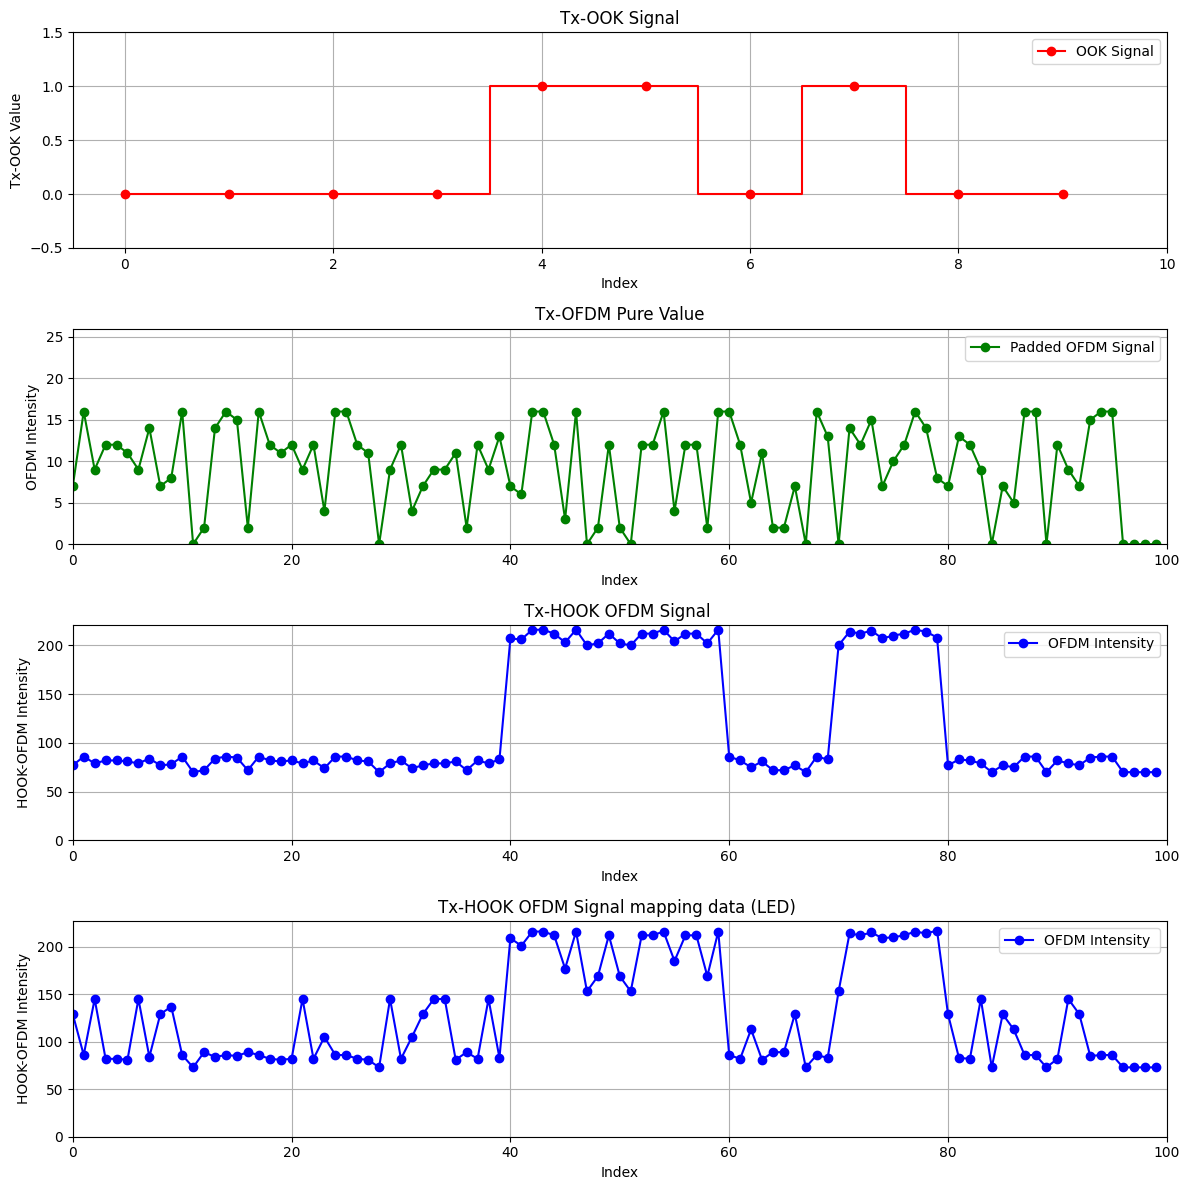

In [41]:
# #Plotting Data in 1st mapping
plt.figure(figsize=(12, 12))

# Subplot 1: OOK Signal
plt.subplot(4, 1, 1)
plt.step(range(len(OOK)), OOK, where='mid', linestyle='-', color='r', marker='o', label="OOK Signal")
plt.ylim(-0.5, 1.5)  # Limit y-axis to 0-1.5
plt.xlim(-0.5, len(OOK))  # Data range
plt.xlabel('Index')
plt.ylabel('Tx-OOK Value')
plt.title('Tx-OOK Signal')
plt.grid(True)
plt.legend()

# Subplot 2: Padded OFDM Signal
plt.subplot(4, 1, 2)
plt.plot(hello1, marker='o', linestyle='-', color='g', label="Padded OFDM Signal")
plt.ylim(0, max(hello1) + 10)  # Adjust y-axis range dynamically
plt.xlim(0, len(hello1))  # Data range
plt.xlabel('Index')
plt.ylabel('OFDM Intensity')
plt.title('Tx-OFDM Pure Value')
plt.grid(True)
plt.legend()

# Subplot 3: OFDM Intensity 1st mapping
plt.subplot(4, 1, 3)
plt.plot(combined_data, marker='o', linestyle='-', color='b', label="OFDM Intensity")
plt.ylim(0, max(combined_data) + 5)  # Intensity range
plt.xlim(0, len(combined_data))  # Data range
plt.xlabel('Index')
plt.ylabel('HOOK-OFDM Intensity')
plt.title('Tx-HOOK OFDM Signal ')
plt.grid(True)
plt.legend()

# Subplot 4: OFDM Intensity 2nd mapping (for real time implementation)
plt.subplot(4, 1, 4)
plt.plot(mapping_HOFDM, marker='o', linestyle='-', color='b', label="OFDM Intensity ")
plt.ylim(0, max(mapping_HOFDM) + 10)  # Intensity range
plt.xlim(0, len(mapping_HOFDM))  # Data range
plt.xlabel('Index')
plt.ylabel('HOOK-OFDM Intensity')
plt.title('Tx-HOOK OFDM Signal mapping data (LED) ')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()